In [ ]:
!pip install --upgrade --ignore-installed kaggle


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadsohail123","key":"629ebb4ab3f9bc22d9c6dd446436e98a"}'}

In [3]:
!mkdir ~/.kaggle #created at root folder in colab

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
#copy
!cp kaggle.json ~/.kaggle

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d darshan1504/covid19-detection-xray-dataset

 97% 180M/186M [00:02<00:00, 80.3MB/s]
100% 186M/186M [00:02<00:00, 79.1MB/s]


In [8]:
#unzip dataset in colab session
!unzip -q covid19-detection-xray-dataset # -q for quiet

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# copy zipped dataset into your drive
!cp "/content/covid19-detection-xray-dataset.zip" /content/drive/MyDrive/

In [2]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.models import model_from_json
from sklearn.preprocessing import LabelBinarizer
import os
from imutils import paths
from tqdm import tqdm
from matplotlib.pyplot import imshow

In [3]:
!ls "/content"

covid19-detection-xray-dataset.zip  kaggle.json        sample_data  ValData
drive				    NonAugmentedTrain  TrainData


In [4]:
train_path = "/content/NonAugmentedTrain"
#dataset path

In [5]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (227, 227))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

In [6]:

print('loading train images')
X_train, y_train = load_data(train_path)

  4%|▍         | 16/412 [00:00<00:02, 159.64it/s]

loading train images


100%|██████████| 60/60 [00:00<00:00, 530.29it/s]


In [8]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)

In [9]:
from keras.models import Sequential
from keras.layers import Dropout

alexnet=Sequential()
# 1st Convolutional Layer 
alexnet.add(Conv2D(filters = 96, input_shape = (227, 227, 3),  kernel_size = (11, 11), strides = (4, 4),  padding = 'valid')) 
alexnet.add(Activation('relu')) 
# Max-Pooling  
alexnet.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid')) 
# Batch Normalisation 
alexnet.add(BatchNormalization()) 
  
# 2nd Convolutional Layer 
alexnet.add(Conv2D(filters = 256, kernel_size = (11, 11), strides = (1, 1), padding = 'valid')) 
alexnet.add(Activation('relu')) 
# Max-Pooling 
alexnet.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2),  padding = 'valid')) 
# Batch Normalisation 
alexnet.add(BatchNormalization()) 
  
# 3rd Convolutional Layer 
alexnet.add(Conv2D(filters = 384, kernel_size = (3, 3),   strides = (1, 1), padding = 'valid')) 
alexnet.add(Activation('relu')) 
# Batch Normalisation 
alexnet.add(BatchNormalization()) 
  
# 4th Convolutional Layer 
alexnet.add(Conv2D(filters = 384, kernel_size = (3, 3),  strides = (1, 1), padding = 'valid')) 
alexnet.add(Activation('relu')) 
# Batch Normalisation 
alexnet.add(BatchNormalization()) 
  
# 5th Convolutional Layer 
alexnet.add(Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'valid')) 
alexnet.add(Activation('relu')) 
# Max-Pooling 
alexnet.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2),  padding = 'valid')) 
# Batch Normalisation 
alexnet.add(BatchNormalization()) 
  
# Flattening 
alexnet.add(Flatten()) 
  
# 1st Dense Layer 
alexnet.add(Dense(4096, input_shape = (227*227*3, ))) 
alexnet.add(Activation('relu')) 
# Add Dropout to prevent overfitting 
alexnet.add(Dropout(0.4)) 
# Batch Normalisation 
alexnet.add(BatchNormalization()) 
  
# 2nd Dense Layer 
alexnet.add(Dense(4096)) 
alexnet.add(Activation('relu')) 
# Add Dropout 
alexnet.add(Dropout(0.4)) 
# Batch Normalisation 
alexnet.add(BatchNormalization()) 
  
# Output Softmax Layer 
alexnet.add(Dense(4)) 
alexnet.add(Activation('softmax')) 



In [10]:

# printing summary of model
alexnet.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0

In [15]:

from sklearn.model_selection import train_test_split

In [17]:
(X_train, X_valid, y_train, y_valid) = train_test_split(X_train, y_train,
                                                        test_size=0.2,
                                                        random_state=42)

In [18]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)

In [19]:
# compiling model
# using categorical_crossentropy loss to Computes the crossentropy loss between the labels and predictions
# -(ylog(p)+(1-y)log(1-p)) is used for cross entropy loss
# the optimizer adam utilizes the concept of momentum by adding fractions of previous gradients to the current one
# matrics =['acuracy'] Calculates how often predictions equal labels and returns
# This metric creates two local variables, total and count that are used to compute the
# frequency with which y_pred matches y_true
alexnet.compile(optimizer = sgd , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [20]:

# training our model
# we are using .fit method instead of .fit_generator because we have tensorflow 2.4.0
hist=alexnet.fit(X_train, y_train,epochs=50, batch_size=128, validation_data=(X_valid, y_valid))

Epoch 1/50
10/10 [==============================] - 3s 179ms/step - loss: 0.5587 - accuracy: 0.8886 - val_loss: 0.1966 - val_accuracy: 0.9346
Epoch 2/50
10/10 [==============================] - 1s 120ms/step - loss: 0.2936 - accuracy: 0.9214 - val_loss: 0.1772 - val_accuracy: 0.9315
Epoch 3/50
10/10 [==============================] - 1s 122ms/step - loss: 0.1722 - accuracy: 0.9284 - val_loss: 0.2617 - val_accuracy: 0.9065
Epoch 4/50
10/10 [==============================] - 1s 122ms/step - loss: 0.1183 - accuracy: 0.9593 - val_loss: 0.1589 - val_accuracy: 0.9439
Epoch 5/50
10/10 [==============================] - 1s 122ms/step - loss: 0.0927 - accuracy: 0.9640 - val_loss: 0.1464 - val_accuracy: 0.9470
Epoch 6/50
10/10 [==============================] - 1s 124ms/step - loss: 0.0597 - accuracy: 0.9818 - val_loss: 0.1333 - val_accuracy: 0.9470
Epoch 7/50
10/10 [==============================] - 1s 123ms/step - loss: 0.0609 - accuracy: 0.9840 - val_loss: 0.1291 - val_accuracy: 0.9533
Epoch 

In [21]:
_# loading validation data
path_test = "/content/ValData"


In [30]:
print('loading test images')
X_test, y_test = load_data(path_test)

  2%|▏         | 5/205 [00:00<00:04, 47.57it/s]

loading test images


100%|██████████| 9/9 [00:00<00:00, 185.59it/s]


In [31]:
y_test = lb.fit_transform(y_test)

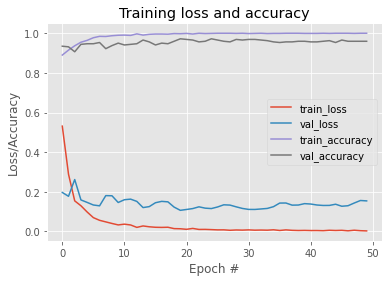

In [32]:
'''LEARNING CURVE'''

import matplotlib.pyplot as plt
N = np.arange(0, 50)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, hist.history['loss'], label='train_loss')
plt.plot(N, hist.history['val_loss'], label='val_loss')
plt.plot(N, hist.history['accuracy'], label='train_accuracy')
plt.plot(N, hist.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [33]:
# checking cross validation accuracy/test accuracy
preds = alexnet.evaluate(X_test,y_test,batch_size=64)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

16/16 [==============================] - 1s 38ms/step - loss: 1.5790 - accuracy: 0.7358
Loss = 1.5789988040924072
Test Accuracy = 0.7358299493789673


In [34]:
import sklearn.metrics as metrics

In [35]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = alexnet.predict_classes(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [36]:
confusion_mtx

array([[201,   0,  17, 106],
       [  2,   4,   3,   0],
       [  1,   1, 436,  12],
       [103,   2,  14,  86]])

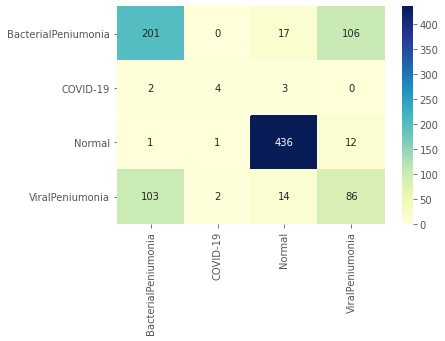

In [37]:
import seaborn as sns
class_names=["BacterialPeniumonia","COVID-19","Normal","ViralPeniumonia"]
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap="YlGnBu")